In [25]:
import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import ccxt
from sqlalchemy import create_engine
import matplotlib
from datetime import datetime, timedelta

with open("../api(JKBOT).txt") as f:
    lines = f.readlines()
    api_key = lines[0].strip()
    secret = lines[1].strip()

binance = ccxt.binance(config={
    'apiKey': api_key, #"XTpKrQGSk3GhXzqiEV4OfwGJzmTVcLh8dKGwHo4aQBH4p0mOqPDpIsxdh95tjGVf",
    'secret': secret, #"A0eqZGEWHsyL3NMM6WuDrucIanr7A2YZAnrwXVPhXpf2WGauIANwa5zsoNeNt0hs",
    'enableRateLimit' : True,
    'options': {
        'defaultType': 'future'
    }
})

jongmok= []

markets = binance.load_markets()
for market in markets.keys():
    if market.endswith("/USDT"):
        jongmok.append(market[:-5].lower())


def md_connect(user, password, db, host, port=3306):
    url = 'mysql+pymysql://{}:{}@{}:{}/{}'.format(user, password, host, port, db)
    engine = create_engine(url).connect()
    return engine

engine = md_connect('root', '1234', 'price_1h', 'localhost')


In [26]:
account = [] # 계좌 정보
diary = [] # 매매일지


window = 48
away = 24

start_date = ''
end_date = ''

tot_data = {}
engine = md_connect('root', '1234', 'price_1d', 'localhost')
for sym in jongmok:
    data = pd.read_sql(sym, engine, index_col='datetime') # 데이터 가져오기
    tot_data[sym] = data

##to_sql ind

In [ ]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.LSTM(10, activation='relu', input_shape=(window, 4), dropout=0.3))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.load_weights('48_24price_1h.h5')

engine = md_connect('root', '1234', 'ind_14_7_d', 'localhost')

for key in jongmok:
    data = tot_data[key]
    x_data = tot_data[key][['open', 'high', 'low', 'close']]
    y_data = tot_data[key][['close']]

    x_input = []
    y_input = []

    ## 전처리
    for i in range(len(data)-window-away+1): #len(data)-window
        mean = x_data[i:i+window].mean()
        std = x_data[i:i+window].std()
        x = (x_data[i:i+window] - mean) / std
        x_input.append(x)
    #
    ## ind 지표 생성
    x_input = np.array(x_input)
    predict_data = model.predict(x_input).tolist()

    ## 수익률 생성
    data['rate'] = data['close'].pct_change(periods=away).shift(-away)

    predict = []
    for i in range(len(predict_data)):
        predict.append(predict_data[i][0])
    data = data[window-1:-away]

    ##ind 지표 결합
    data['ind'] = predict
    print(len(data))

    data['sym'] = key

    data = data[['sym', 'open', 'high', 'low', 'close', 'rate', 'ind']]
    engine = md_connect('root', '1234', 'ind_48_24_h', 'localhost')
    data.to_sql(key, engine, if_exists="replace", index=True)

In [5]:
for sym in jongmok[:100]:
    data = pd.read_sql(sym, engine, index_col='datetime') # 데이터 가져오기
    tot_data[sym] = data

In [20]:
# 변수 설정
ind_data = []
for key in jongmok[50:80]:
    ind_data.append(tot_data[key][['sym', 'close', 'rate', 'ind']])

ind_data = pd.concat(ind_data)


def select_rate(long_std, short_std, start_date=0, end_date=0, fee=0):
    df = ind_data[(ind_data['ind'] > long_std) | (ind_data['ind'] < short_std)].sort_index()
    condition = df['ind'] > 0.5
    df = df.assign(position=condition.map({True:1, False:-1}))
    df['profit'] = df['position'] * df['rate'] -(2 * fee)

    if start_date != 0:
        if end_date != 0:
            df = df.loc[start_date:end_date]
        else:
            df = df.loc[start_date:]
    else:
        if end_date !=0:
            df = df.loc[:end_date]


    df['count_sum'] = df.groupby('datetime').count()['sym'].rolling(window=7, min_periods=1).sum()
    df['tot_profit'] = df['profit'].cumsum()

    return df

In [21]:
log_column = ['시작', '끝', '거래기간', '매수조건', '매도조건', '거래 횟수', '승률', '승수', '패수', '평균보유량', '평균수익률', '총수익률']
log_df = pd.DataFrame(columns = log_column)

C:\Users\tomkj\AppData\Local\Temp\ipykernel_140996\3037101066.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append(log, ignore_index=True)


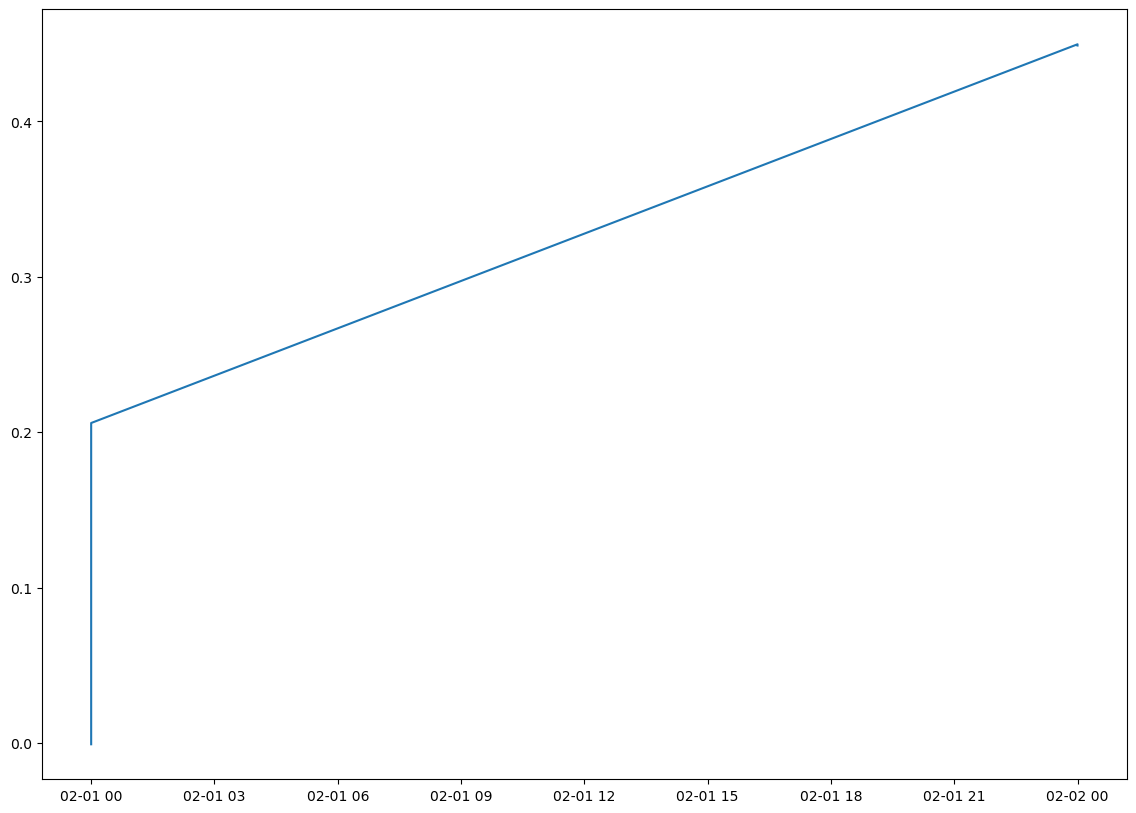

,시작,끝,거래기간,매수조건,매도조건,거래 횟수,승률,승수,패수,평균보유량,평균수익률,총수익률
0,2023-02-01,2023-02-15,14,0.65,0.35,12,0.5,6,6,9.083333,0.026352,0.316230
1,2023-02-01,2023-02-15,14,0.70,0.30,4,0.5,2,2,3.000000,0.112207,0.448826


In [24]:
import matplotlib.pyplot as plt
start_date = '2023-02-01'
end_date = '2023-02-15'
long_std = 0.7
short_std = 0.3
start_date = datetime.strptime(start_date, '%Y-%m-%d')
end_date =  datetime.strptime(end_date, '%Y-%m-%d')

df = select_rate(long_std, short_std, start_date, end_date, 0.0004)

win_cnt = (df['profit'] > 0).sum()
lose_cnt = (df['profit'] < 0).sum()

day = end_date - start_date
day.days

# log.append([len(df), day.days, win_cnt / len(df), win_cnt, lose_cnt, df['count_sum'].mean(), df['profit'].mean(), df['profit'].sum()])
log = {'시작' : start_date, '끝' : end_date, '매수조건' : long_std, '매도조건' : short_std, '거래 횟수' : len(df), '거래기간' : day.days, '승률' : win_cnt / len(df), '승수' : win_cnt, '패수' : lose_cnt, '평균보유량' : df['count_sum'].mean(), '평균수익률' : df['profit'].mean(), '총수익률' : df['profit'].sum()}
log_df = log_df.append(log, ignore_index=True)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(1, 1, 1)
# # ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(df['tot_profit'], label='close')
# # ax2.plot(result[3]['tot_profit'], label='tot_profit')
plt.show()
log_df

In [23]:
log_df

,시작,끝,거래기간,매수조건,매도조건,거래 횟수,승률,승수,패수,평균보유량,평균수익률,총수익률
0,2023-02-01,2023-02-15,14,0.65,0.35,12,0.5,6,6,9.083333,0.026352,0.31623


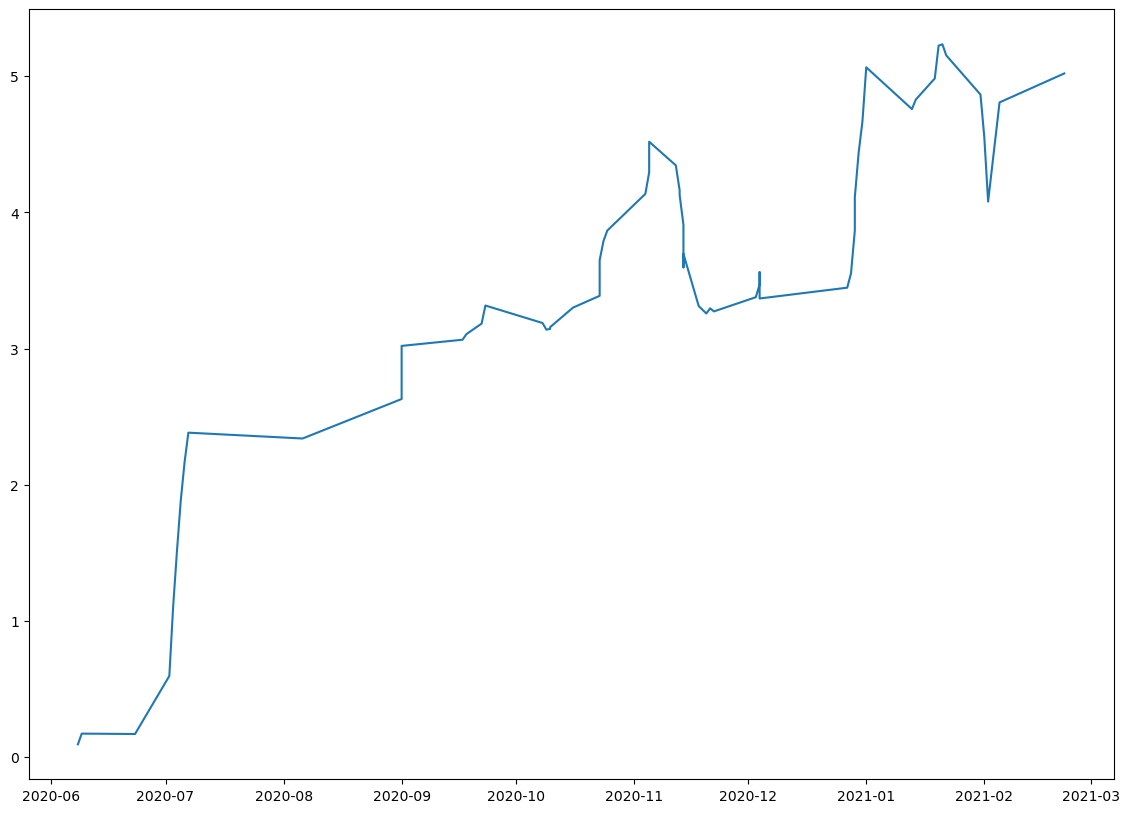

In [338]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(1, 1, 1)
# ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(df['tot_profit'], label='close')
# ax2.plot(result[3]['tot_profit'], label='tot_profit')
plt.show()

input 날짜, 종목